In [1]:
import geopandas as gpd
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

# Load the GeoJSON file to inspect its structure
file_path = '../data/processed/Bayern/verkehrslinie-Garching-Basemap-by-kennung.geojson'
streetsbykennung = gpd.read_file(file_path)

# Display the first few rows of the data to understand its structure
streetsbykennung.head()

,id,land,objektart,klasse,klasse_org,name,name_kurz,zweitname,nummer,e_nummer1,...,spurweite,spurweite_name,typ,typ_name,kennung,bauwerk,bauwerk_name,fahrbahnachse,ebene,geometry
0,DEBYBDLMZS0001ZI,BY,Strassenachse,Gemeindestraße,1307.0,Isarstraße,Isarstr.,None,None,None,...,None,None,None,None,09184119000100000,None,None,NaN,0,"LINESTRING (11.67277 48.26347, 11.67247 48.26353)"
1,DEBYBDLMZS00043y,BY,Strassenachse,Gemeindestraße,1307.0,Am Coulombwall,A. Coulombwall,None,None,None,...,None,None,None,None,09184119000100000,None,None,NaN,0,"LINESTRING (11.67583 48.26894, 11.67541 48.269)"
2,DEBYBDLMZR0005OR,BY,Strassenachse,"Landesstraße, Staatsstraße",1305.0,Freisinger Landstraße,Freising. Landstr.,None,St2350,None,...,None,None,None,None,09184119000100000,None,None,NaN,0,"LINESTRING (11.66259 48.26792, 11.66331 48.268..."
3,DEBYBDLMZS0001Ut,BY,Strassenachse,Gemeindestraße,1307.0,Isarstraße,Isarstr.,None,None,None,...,None,None,None,None,09184119000100000,None,None,NaN,0,"LINESTRING (11.67331 48.26338, 11.67301 48.26344)"
4,DEBYBDLMZS0001Vf,BY,Strassenachse,Gemeindestraße,1307.0,Flurstraße,Flurstr.,None,None,None,...,None,None,None,None,09184119000100000,None,None,NaN,0,"LINESTRING (11.67404 48.26067, 11.67411 48.260..."


In [3]:
# Load the GeoJSON file to inspect its structure
file_path = '../data/processed/Bayern/verkehrslinie-Garching-Basemap-by-region.geojson'
streetsbyregion = gpd.read_file(file_path)

# Display the first few rows of the data to understand its structure
streetsbyregion.head()

,id,land,objektart,klasse,klasse_org,name,name_kurz,zweitname,nummer,e_nummer1,...,spurweite,spurweite_name,typ,typ_name,kennung,bauwerk,bauwerk_name,fahrbahnachse,ebene,geometry
0,DEBYBDLMZS0001ZI,BY,Strassenachse,Gemeindestraße,1307.0,Isarstraße,Isarstr.,None,None,None,...,NaN,None,NaN,None,09184119000100000,None,None,NaN,0,"LINESTRING (11.67277 48.26347, 11.67247 48.26353)"
1,DEBYBDLMZS00043y,BY,Strassenachse,Gemeindestraße,1307.0,Am Coulombwall,A. Coulombwall,None,None,None,...,NaN,None,NaN,None,09184119000100000,None,None,NaN,0,"LINESTRING (11.67583 48.26894, 11.67541 48.269)"
2,DEBYBDLMZS0000gI,BY,Fahrwegachse,Hauptwirtschaftsweg,5211.0,None,None,None,None,None,...,NaN,None,NaN,None,None,None,None,NaN,0,"LINESTRING (11.66547 48.2514, 11.66569 48.2514..."
3,DEBYBDLMZR0001U3,BY,Strassenachse,Bundesautobahn,1301.0,None,None,None,A9,None,...,NaN,None,NaN,None,None,None,None,NaN,0,"LINESTRING (11.64105 48.24699, 11.64124 48.246..."
4,DEBYBDLMZR0001A5,BY,Fahrwegachse,Hauptwirtschaftsweg,5211.0,None,None,None,None,None,...,NaN,None,NaN,None,None,None,None,NaN,0,"LINESTRING (11.6623 48.25136, 11.66246 48.2513..."


In [4]:
# Extract necessary columns for building the network graph
kennung_data = streetsbykennung[['name', 'geometry','kennung']]
region_data = streetsbyregion[['name', 'geometry','kennung']]
two_data = {"bykennung":kennung_data,"byregion": region_data}
two_graph = {}
for key in two_data:

    # Build a NetworkX graph from the GeoDataFrame
    G = nx.Graph()

    # Add edges to the graph based on street geometries
    for _, row in two_data[key].iterrows():
        street_name = row['name']
        street_kennung = row['kennung']
        geometry = row['geometry']

        # If the geometry is a LineString, extract coordinates
        if geometry.geom_type == 'LineString':
            coords = list(geometry.coords)
            # Add nodes and edges for each segment in the LineString
            for i in range(len(coords) - 1):
                start = coords[i]
                end = coords[i + 1]
                G.add_edge(start, end, street_name=street_name)
        # If the geometry is a MultiLineString, process each LineString
        elif geometry.geom_type == 'MultiLineString':
            for linestring in geometry:
                coords = list(linestring.coords)
                for i in range(len(coords) - 1):
                    start = coords[i]
                    end = coords[i + 1]
                    G.add_edge(start, end, street_name=street_name)

    # Create Street Key Table: Map street names to edge keys
    street_key_table = []
    for edge in G.edges(data=True):
        street_key_table.append({'street_name': edge[2]['street_name'], 'edge': (edge[0], edge[1])})

    # Create Edge Table: Details of all edges
    edge_table = []
    for edge in G.edges(data=True):
        edge_table.append({'start': edge[0], 'end': edge[1], 'street_name': edge[2]['street_name']})

    # Create Vertex Table: List of all nodes
    vertex_table = [{'vertex': node, 'coordinates': node} for node in G.nodes()]

    two_graph[key] = G
    # Convert to DataFrames for better representation
    street_key_df = pd.DataFrame(street_key_table)
    edge_df = pd.DataFrame(edge_table)
    vertex_df = pd.DataFrame(vertex_table)

In [5]:

# Function to visualize graphs side by side
def plot_graphs(graph1, graph2, titles=("Graph 1", "Graph 2")):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Plot the first graph
    pos1 = nx.spring_layout(graph1)  # Generate positions for nodes
    nx.draw(graph1, pos1, ax=axes[0], with_labels=False, node_size=20, edge_color="blue")
    axes[0].set_title(titles[0])

    # Plot the second graph
    pos2 = nx.spring_layout(graph2)  # Generate positions for nodes
    nx.draw(graph2, pos2, ax=axes[1], with_labels=False, node_size=20, edge_color="green")
    axes[1].set_title(titles[1])

    plt.show()

# Check graph equality
def check_graph_equality(graph1, graph2):
    isomorphic = nx.is_isomorphic(graph1, graph2)
    print("Are the graphs isomorphic? ", isomorphic)

    # Optionally check for exact edge and node match
    equal_nodes = set(graph1.nodes) == set(graph2.nodes)
    equal_edges = set(graph1.edges) == set(graph2.edges)
    print("Nodes equal: ", equal_nodes)
    print("Edges equal: ", equal_edges)



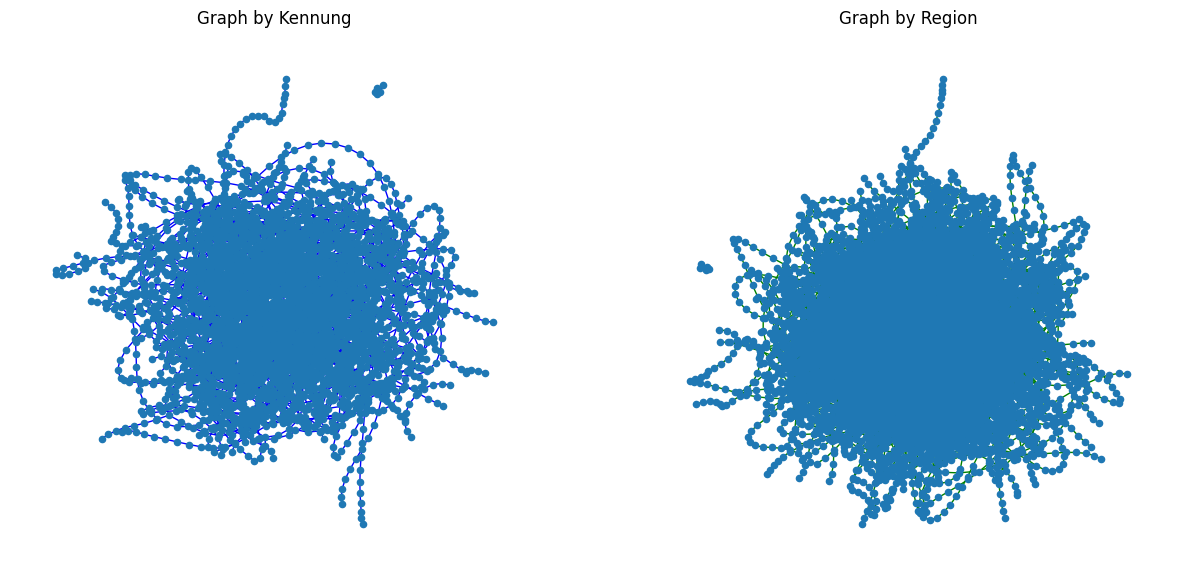

Are the graphs isomorphic?  False
Nodes equal:  False
Edges equal:  False


In [6]:
# Plot and test equality
plot_graphs(two_graph["bykennung"], two_graph["byregion"], titles=("Graph by Kennung", "Graph by Region"))
check_graph_equality(two_graph["bykennung"], two_graph["byregion"])